<a href="https://colab.research.google.com/github/ragul1995/TIme_Series/blob/master/08_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages
One of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.


## Perform standard imports and load datasets

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('drive/My Drive/Data/co2_mm_mlo.csv')

### Inspect the dataset (EDA)

In [5]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [0]:
# Add a "date" datetime column
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

#Alternative solution
# df['date'] = pd.to_datetime({'year':df['year'],'month':df['month'],'day':df['day']})

In [10]:
# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [19]:
print(f"Starts from {df.index.year.min()} ends {df.index.year.max()}")

Starts from 1958 ends 2018


### Visualization

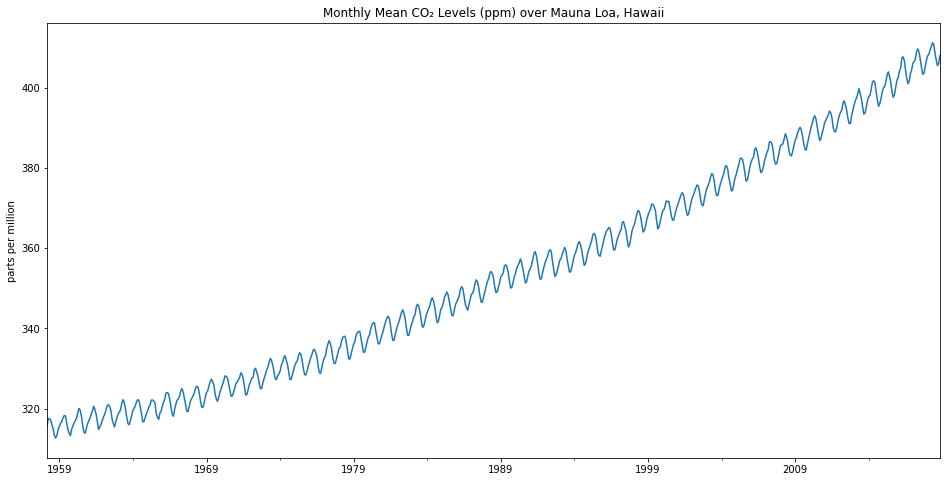

In [12]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(16,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

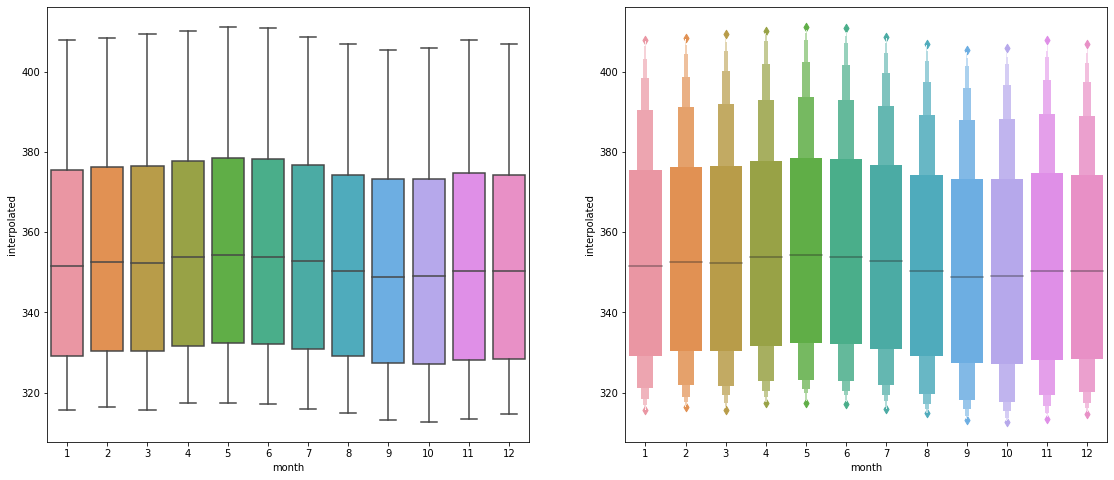

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(19,8))
sns.boxplot(df['month'],df['interpolated'],ax=ax[0])
sns.boxenplot(df['month'],df['interpolated'],ax=ax[1]);

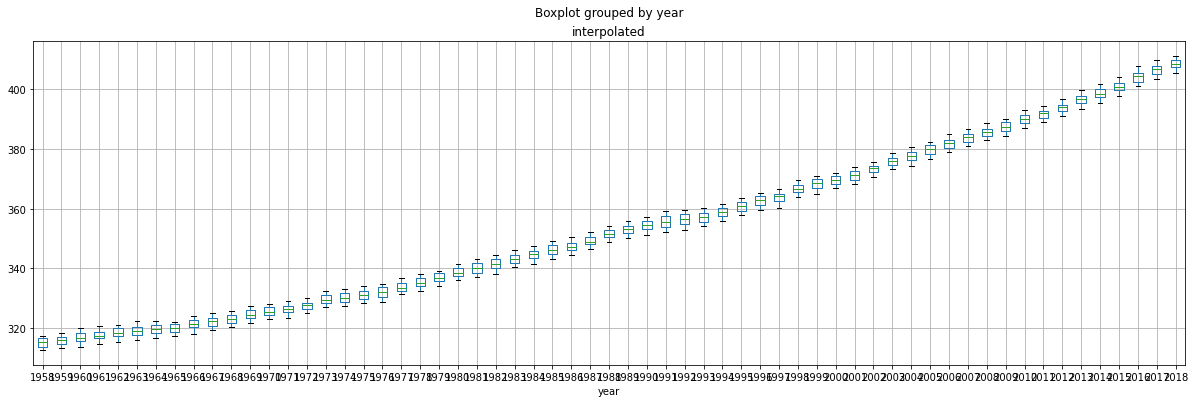

In [30]:
df.boxplot(column='interpolated',by='year',figsize=(20,6));

As we can see from the yearly boxplot, it's evident that CO2 level has increased significantly.

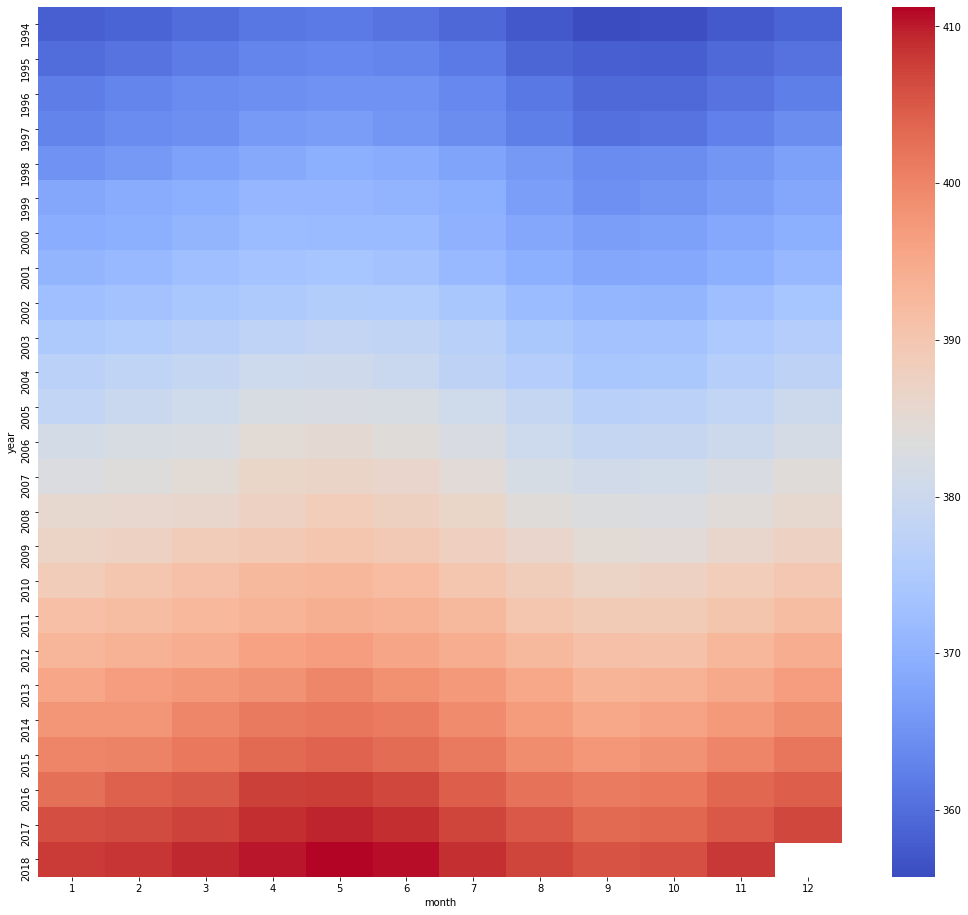

In [113]:
plt.figure(figsize=(18,16))
sns.heatmap(df.pivot_table(columns='month',index='year',values='interpolated').tail(25),cmap='coolwarm') #for last 25 years only

It's much clear that how co2 level has been changed over time. That's a concern for everyone in hawaii.

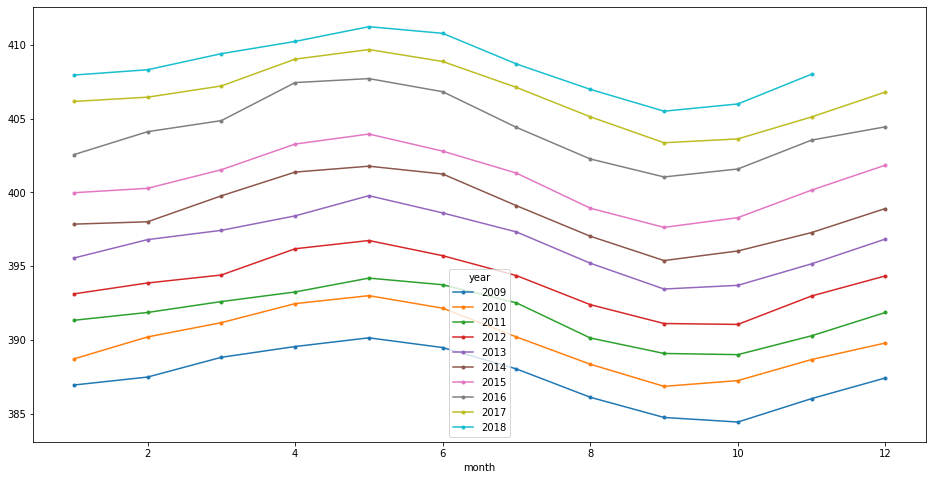

In [119]:
last_10yr = df.pivot_table(columns='month',index='year',values='interpolated').tail(10)

last_10yr.T.plot(figsize=(16,8),legend='best',linestyle='-', marker='.');

### ETS Decomposition

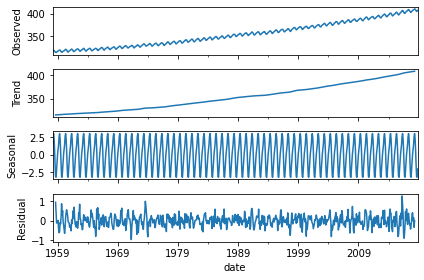

In [13]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

It looks like indeed there is some seasonality for all the data, so we will keep this in mind. We will work with a SARIMAX model to account for all factors.

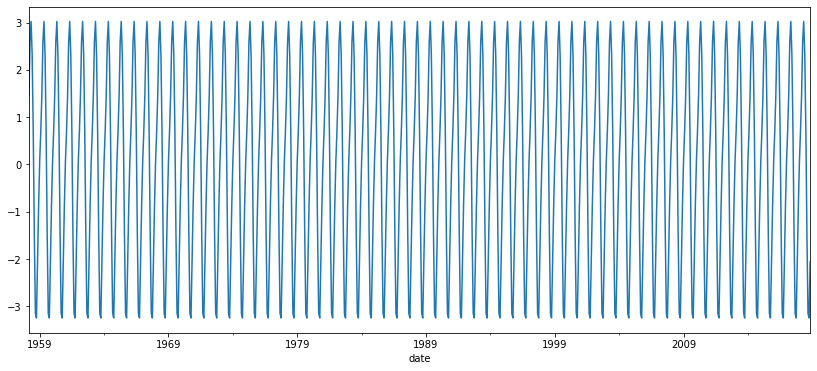

In [15]:
result.seasonal.plot(figsize=(14,6));

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# create function to plot ACF and PACF
def acf_pacf(ts,alags=40,plags=40):
    '''Takes timeseries and plots ACF and PACF'''
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
    plot_acf(ts,lags=alags, zero=True,ax=ax1)
    plot_pacf(ts,lags=plags, ax=ax2, method = 'ywmle')
    plt.show();

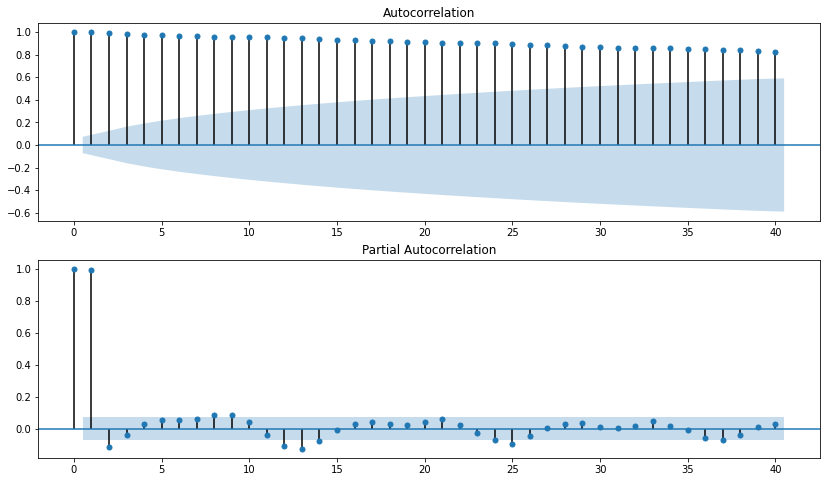

In [48]:
acf_pacf(df['interpolated'])

In [0]:
def fit_sarimax_model(ts, order=(1,1,1), seasonal_order=(0, 0, 0, 12), summary=True, plot=True):
    
    '''Takes a time series and runs a SARIMAX model with parameter order provided. 
    If no parameter provided default is (1,1,1), (0,0,0,12). 
    Has the default option to print model summary and plot diagnostics, which can be turned off'''
  
    # fit model
    model = SARIMAX(ts,
                    order=order,
                    seasonal_order=seasonal_order,
                    trend='ct',
                    enforce_stationarity=True,
                    enforce_invertibility=False)
    output = model.fit(d=0)
    
    if summary==True:
        print(output.summary())

    if plot==True:
        # plot model diagnostics
        output.plot_diagnostics(figsize=(15, 18))
        plt.show()
        
    return output

                           Statespace Model Results                           
Dep. Variable:           interpolated   No. Observations:                  729
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -888.423
Date:                Thu, 07 May 2020   AIC                           1786.847
Time:                        04:20:29   BIC                           1809.798
Sample:                    03-01-1958   HQIC                          1795.703
                         - 11-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0319      0.084      0.380      0.704      -0.133       0.197
drift       7.195e-05      0.000      0.380      0.704      -0.000       0.000
ar.L1          0.5622      0.043     13.156      0.0

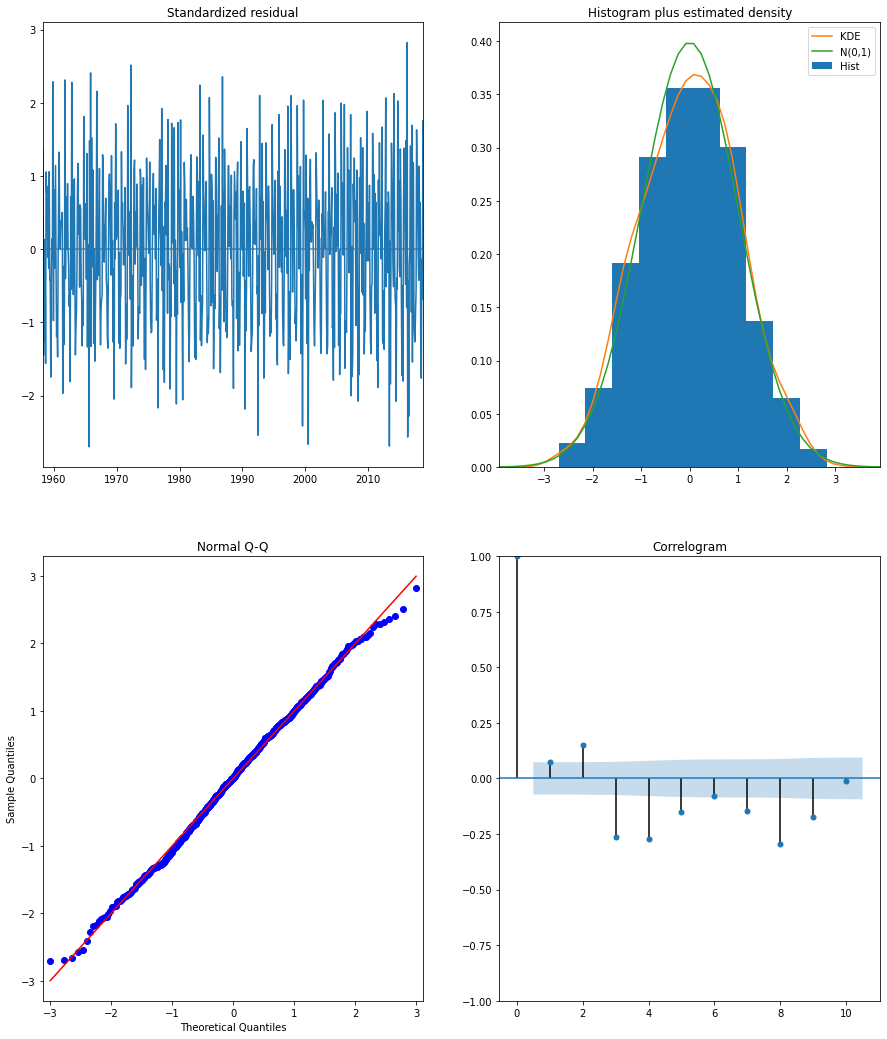

In [35]:
output = fit_sarimax_model(df['interpolated'],summary=True,plot=True)

From above diagnostic plots, our residuals are quite normally distributed!! Instead of manually running each and every oreders, pmdarima module will search best orders for us.

### To obtain recommended orders

In [37]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -209.434
Date:                            Thu, 07 May 2020   AIC                            428.867
Time:                                    04:33:12   BIC                            451.819
Sample:                                         0   HQIC                           437.723
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.539e-05      0.000      0.211      0.833      -0.000       0.000
ma.L1         -0.3726      0.035    -10.723      0.000      -0.441      -0.304
ar.S.L12       0.9996      0.000   2875.523      0.000       0.999       1.000
ma.S.L12      -0.8658      0.022    -39.475      0.000      -0.909      -0.823
sigma2         0.0976      0.005     20.059      0.000       0.088       0.107
===================================================================================
Ljung-Box (Q):                       51.90   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.10   Prob(JB):                         0.16
Heteroskedasticity (H):               1.12   Skew:                            -0.04
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (0,1,1) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(0,1,1)(1,0,1,12) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [38]:
len(df)

729

In [0]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

### SARIMA Model

                                 Statespace Model Results                                 
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -520.846
Date:                            Thu, 07 May 2020   AIC                           1053.691
Time:                                    04:37:05   BIC                           1081.133
Sample:                                03-01-1958   HQIC                          1064.288
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.546      0.585      -0.001       0.002
drift       1.914e-06   7.05e-06   

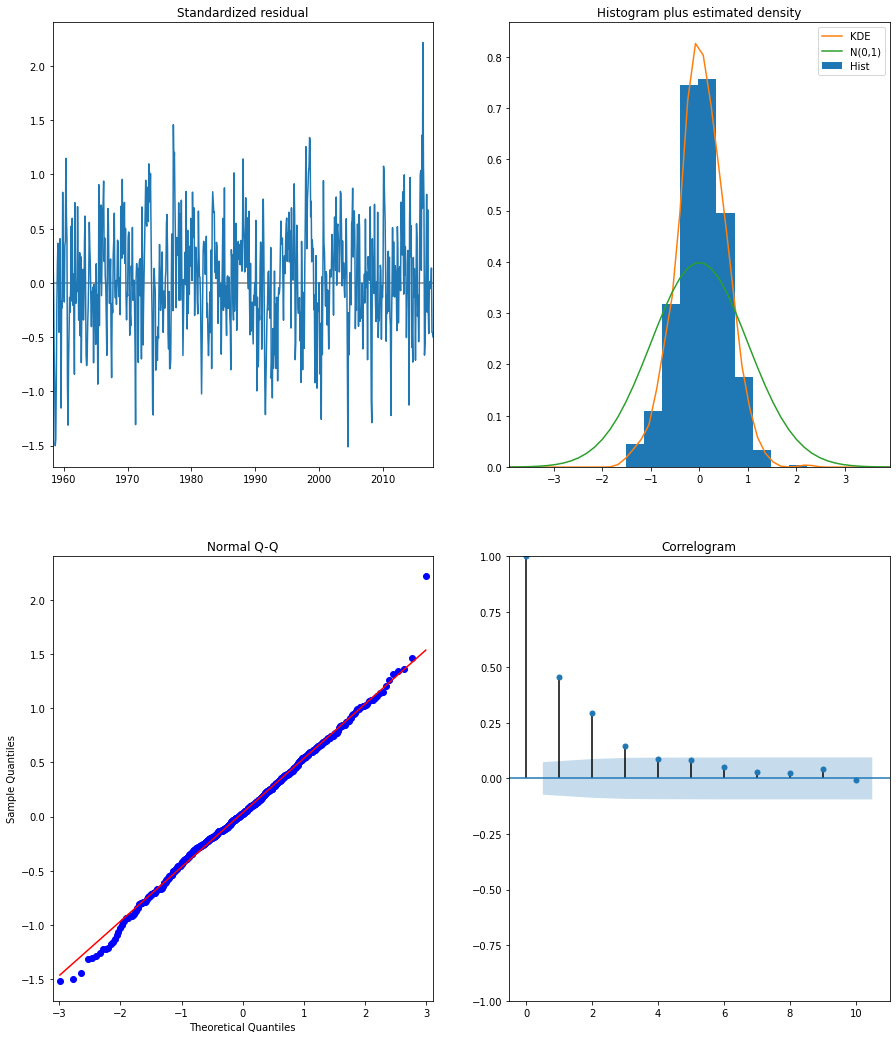

In [41]:
results = fit_sarimax_model(train['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12),summary=True,plot=True)

In [0]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1)(1,0,1,12) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

In [43]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.8013417, expected=406.81
predicted=408.0174129, expected=407.96
predicted=408.746744 , expected=408.32
predicted=409.6641134, expected=409.41
predicted=411.3151936, expected=410.24
predicted=411.9315731, expected=411.24
predicted=411.1199339, expected=410.79
predicted=409.4001163, expected=408.71
predicted=407.3152319, expected=406.99
predicted=405.8800332, expected=405.51
predicted=406.2032028, expected=406.0
predicted=407.7770193, expected=408.02


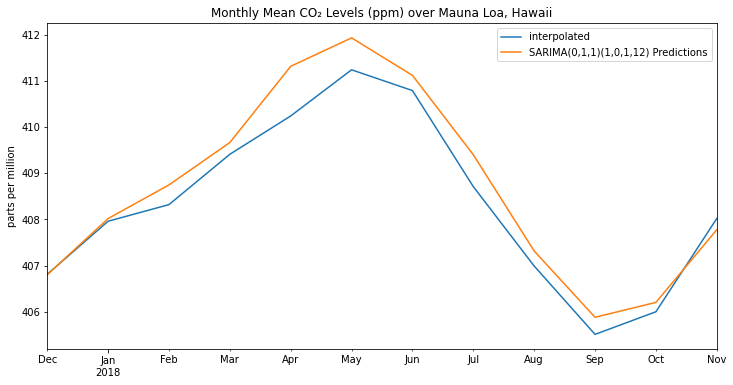

In [44]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the Model

In [45]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,1)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,1)(1,0,1,12) MSE Error: 0.2343764981


In [46]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,1)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,1)(1,0,1,12) RMSE Error: 0.4841244655


These are outstanding results!
### Retrain the model on the full data, and forecast the future

In [0]:
model = SARIMAX(df['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
fcast0 = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,1)(1,0,1,12) Forecast')

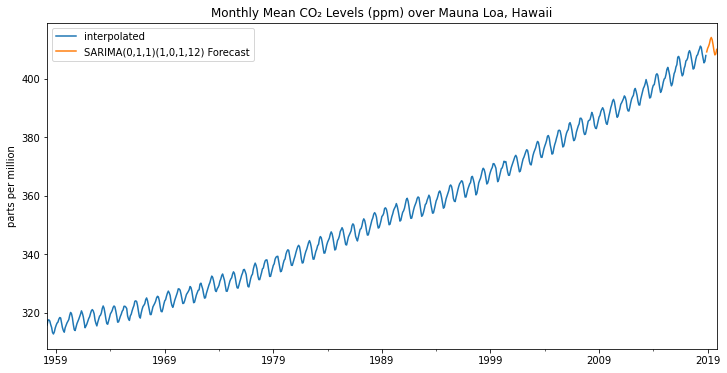

In [100]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast0.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Confidence Interval

In [76]:
# Here we construct a more complete results object.
fcast_res1 = results.get_forecast()

# Here we specify that we want a confidence level of 95%
print(fcast_res1.summary_frame(alpha=0.05))

interpolated        mean   mean_se  mean_ci_lower  mean_ci_upper
2018-12-01    409.266614  0.310436     408.658171     409.875057


The default confidence level is 95%, but this can be controlled by setting the alpha parameter, where the confidence level is defined as **(1−α)×100%.**

In [102]:
# Here we construct a more complete results for next 12 months.
fcast_res1 = results.get_forecast(steps=12)


pd.DataFrame(fcast_res1.summary_frame(alpha=0.05))

interpolated,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-12-01,409.266614,0.310436,408.658171,409.875057
2019-01-01,410.461568,0.366635,409.742976,411.180160
2019-02-01,411.154311,0.415298,410.340342,411.968280
2019-03-01,412.084376,0.458828,411.185089,412.983663
2019-04-01,413.545014,0.498572,412.567830,414.522198
2019-05-01,414.202039,0.535374,413.152725,415.251353
2019-06-01,413.465529,0.569804,412.348734,414.582324
2019-07-01,411.721854,0.602269,410.541430,412.902279
2019-08-01,409.673225,0.633071,408.432430,410.914021
2019-09-01,408.219504,0.662442,406.921142,409.517867


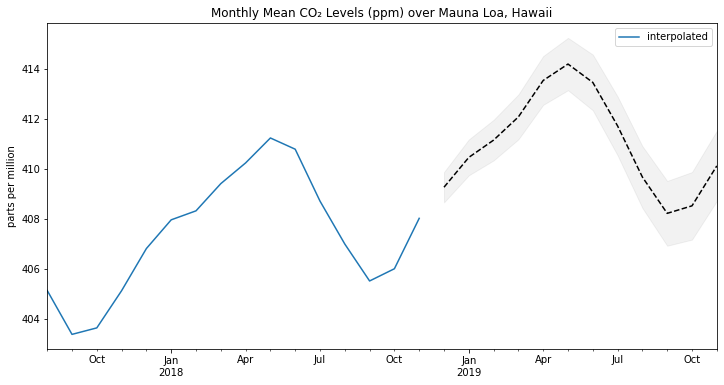

In [104]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df.loc['2017-08-01':]['interpolated'].plot(legend=True,figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

# Construct the forecasts
fcast = results.get_forecast(steps=12).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.05);